In [1]:
"""
computes the unitary DFT by:

1) using Weyl's unitary trick to get unitary representations
2) use orthogonal representations which are unitary since they're real
3) just compute DFT.DFT^* = D, where D is diagonal. then factor D = RR^*, and uDFT = R^{-1}.DFT

""";

In [2]:
#compute a field which contains all the square roots required
def number_field_with_all_square_roots(SGA):
    group_size = G.cardinality()
    required_square_roots = []
    for partition in Partitions(G.degree()):
        specht_module = SGA.specht_module(partition)
        rho = specht_module.representation_matrix
        P = (1/group_size)*sum(rho(g)*rho(g).H for g in G)
        d, L = P.eigenmatrix_left()
        required_square_roots += [specht_module.dimension(),group_size] + d.diagonal()
    required_square_roots = {e for q in required_square_roots for e in ([QQ(q).numerator(), QQ(q).denominator()] if q in QQ else [q])}
    K = SGA.base_ring()
    for n in required_square_roots:
        R = PolynomialRing(K, 'x')
        x = R.gen()
        if n in QQ and (x**2-n).is_irreducible():
            gen_name = f"sqrt{str(n).replace('/','over')}"
            K = K.extension(x**2-n,names=gen_name)
        #BUG: the required square roots are not all integers. some of them are algebraic numbers
        #this is incredibly slow and will even segfault.
        if not n in QQ and sqrt(n).minpoly().is_irreducible():
            gen_name = f"deg{n.minpoly().degree()}index{list(set(required_square_roots)).index(n)}"
            K = K.extension(sqrt(n).minpoly(),names=gen_name)
    return K

In [3]:
#find the change-of-basis matrix Q making \rho(g) unitary for all g \in G
def unitary_change_of_basis(SGA,partition,K=QQbar):
    rho = SGA.specht_module(partition).representation_matrix
    group_size = SGA.group().cardinality()
    P = (1/group_size)*sum(rho(g)*rho(g).H for g in G)
    d, L = P.eigenmatrix_left()
    return L.inverse() * diagonal_matrix([sqrt(K(a)) for a in d.diagonal()]) * L

In [4]:
#define the Fourier coefficient at the representation specht_module
#which is the Specht module corresponding to partition
def hat(g,partition,SGA,K=QQbar,method=None):
    specht_module = SGA.specht_module(partition)
    rho = specht_module.representation_matrix
    if not method:
        return rho(g)
    if method == "orth":
        rho_orth = SymmetricGroupRepresentation(partition, "orthogonal")
        unitary_factor = specht_module.dimension()/G.cardinality()
        sqrt_unitary_factor = sqrt(unitary_factor)
        return sqrt_unitary_factor*rho_orth(g)
    if method == "unitary":
        Q = unitary_change_of_basis(SGA,partition,K)
        unitary_factor = specht_module.dimension()/G.cardinality()
        sqrt_unitary_factor = sqrt(K(unitary_factor))
        return sqrt_unitary_factor*Q.inverse()*rho(g)*Q

In [5]:
#for each basis element g \in G compute the Fourier coefficients \hat{\delta_g}(partition) for all partitions
def dft(SGA,method=None,number_field=False):
    K = number_field_with_all_square_roots(SGA) if number_field else QQbar
    fourier_transform = [[x for partition in Partitions(G.degree()) for x in hat(g,partition,SGA,K,method).list()] for g in G]
    if not method:
        return matrix(fourier_transform).transpose()
    if method == "orth":
        return matrix(fourier_transform).transpose()
    if method == "unitary":
        return matrix(K,fourier_transform).transpose()

In [6]:
#an alternate method to create a unitary DFT in characteristic zero, avoiding other computations
#take the numerators and denominators of the diagonal, factor square-free parts, and adjoin roots of resulting primes
def unitary_dft(SGA):
    SGA_dft = SGA.dft()
    diag = (SGA_dft*SGA_dft.transpose()).diagonal()
    if SGA.base_ring() != QQbar:
        primes_needed = {factor for d in diag for factor, _ in d.squarefree_part().factor()}
        names = [f"sqrt{factor}" for factor in primes_needed]
        x = PolynomialRing(QQ, 'x').gen()
        K = NumberField([x**2-d for d in primes_needed],names=names)
    else:
        K = QQbar
    diag_inv = diagonal_matrix([~sqrt(K(d)) for d in diag])
    return diag_inv*SGA_dft

In [93]:
#define paramters, algebra, field, group
n = 3
SGA = SymmetricGroupAlgebra(QQ,n)
G = SGA.group()

In [94]:
U_dft = unitary_dft(SGA)

In [95]:
U_dft.base_ring().gens()

(sqrt2, sqrt3)

In [96]:
charpoly = U_dft.charpoly(); charpoly

x^6 + 1/2*x^5 + (1/6*sqrt2 + 1/2*sqrt3 - 1/2)*x^4 + (-1/6*sqrt2 - 1/2*sqrt3 + 1/2)*x^2 - 1/2*x - 1

In [97]:
K = charpoly.base_ring()

In [98]:
E, phi = charpoly.splitting_field('a',map=True)

In [99]:
#pushforward charpoly to be in E[y] rather than K[x] via embedding phi: K --> E
charpoly_E = sum([phi(charpoly[i])*PolynomialRing(E,'y').gen()**i for i in range(charpoly.degree()+1)])

In [100]:
charpoly_E.roots()

[(1, 1), (-1, 1)]

In [84]:
E.galois_group()

Galois group of (non-Galois) x^32 + 120*x^31 - 17532*x^30 - 2667888*x^29 + 110651166*x^28 + 26041904784*x^27 - 166343408892*x^26 - 147724751060208*x^25 - 1705949357837175*x^24 + 544937224178466648*x^23 + 12471702287965613136*x^22 - 1390581196176336103296*x^21 - 43346886886235415490560*x^20 + 2557958956714503501329664*x^19 + 96755891829193726806716928*x^18 - 3503629949932179556791146496*x^17 - 151395572335222808405433533952*x^16 + 3684983862573146705058307289088*x^15 + 172370595677920869748211479388160*x^14 - 3077042345044183858609847805640704*x^13 - 144779797808166587985468605777264640*x^12 + 2107428055487671672601572441112838144*x^11 + 89285267546764977359078892645873352704*x^10 - 1200887878808706816431831839664235872256*x^9 - 39318237272944231501700968110187217879040*x^8 + 553745985553878787636478221737544839069696*x^7 + 11530713978523144209899886253069489557995520*x^6 - 190655499159926700770611195917444516849647616*x^5 - 1868260132414457800228677091504693126147080192*x^4 + 424867361

In [82]:
eigenvalues = U_dft.charpoly().roots()

In [105]:
#compute the GCD of the characteristic polynomial and its derivative
gcd(charpoly,charpoly.derivative())

1

In [106]:
charpoly.derivative()

6*x^5 + 5/2*x^4 + (2/3*sqrt2 + 2*sqrt3 - 2)*x^3 + (-1/3*sqrt2 - sqrt3 + 1)*x - 1/2

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eigenvalue[0].real() for eigenvalue in eigenvalues]
imaginary_parts = [eigenvalue[0].imag() for eigenvalue in eigenvalues]

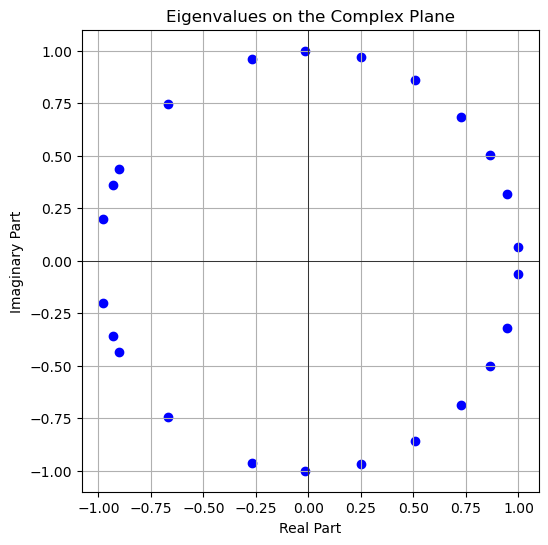

In [94]:
# Plotting the eigenvalues on the complex plane
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Eigenvalues on the Complex Plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

In [7]:
SGA_dft = SGA.dft(); SGA_dft

24 x 24 dense matrix over Rational Field (use the '.str()' method to see the entries)

In [8]:
#check if A*A^T == Id. it's not, but the columns are orthonormal
print((SGA_dft*SGA_dft.transpose()).diagonal())

[24, 8, 6, 16/3, 32/3, 8, 64/9, 12, 9, 8, 12, 9, 16, 12, 8, 64/9, 16/3, 9, 8, 6, 12, 32/3, 8, 24]


In [9]:
#orthogonal representations only use square roots. should work over number field containing square roots vs. symbolic ring
SymmetricGroupRepresentation(Partition([2,1,1]), "orthogonal").representation_matrix(G[7])

[          -1            0            0]
[           0          1/3 -2/3*sqrt(2)]
[           0 -2/3*sqrt(2)         -1/3]

In [10]:
#alternate method using orthogonal representations over symbolic ring
U_dft = dft(SGA,method="orth"); print(U_dft)

[                 1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)                  1/2*sqrt(1/6)]
[                 1/2*sqrt(1/2)                 -1/6*sqrt(1/2)                  1/2*sqrt(1/2)                 -1/6*sqrt(1/2)                 -1/6*sqrt(1/2)                 -1/6*sqrt(1/2)                  1/2*sqrt(1/2)                 -1/6*sqrt(1/2)      

In [12]:
#compute the unitary DFT for the symmetric group algebra by constructing the number field explicitly
U_dft = dft(SGA,method="unitary",number_field=True); print(U_dft)

NameError: name 'number_field_with_all_square_roots' is not defined

In [15]:
#compute using the simplest method
U_dft = unitary_dft(SGA); print(U_dft)

[-1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2]
[       1/3*sqrt3        1/6*sqrt3       -1/3*sqrt3       -1/6*sqrt3       -1/6*sqrt3        1/6*sqrt3]
[               0              1/2                0              1/2             -1/2             -1/2]
[               0              1/2                0             -1/2              1/2             -1/2]
[       1/3*sqrt3       -1/6*sqrt3        1/3*sqrt3       -1/6*sqrt3       -1/6*sqrt3       -1/6*sqrt3]
[-1/6*sqrt3*sqrt2  1/6*sqrt3*sqrt2  1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2 -1/6*sqrt3*sqrt2  1/6*sqrt3*sqrt2]


In [16]:
#check that the DFT is unitary
U_dft*U_dft.H == identity_matrix(G.cardinality())

True

In [19]:
#QUESTION: what are the eigenvalues?
#for n=3, the minimal polynomial is degree 24 for the eigenvalues. [L:\Q] = 192, [L:K] = |Gal(L/K)| = [L:\Q]/[K:\Q] = 192/4 = 48
#there is only one subgroup of order 48 in S_6, S_2 x S_4. however, there is only one transitive permutation group, S_2 \wr S_3
#the eigenvalues are not roots of unity since min_poly(x) has rational coefficients and cyclotomic polynomials have integer coefficients

In [39]:
U_dft.charpoly()

x^6 + 1/2*x^5 + (1/6*sqrt2 + 1/2*sqrt3 - 1/2)*x^4 + (-1/6*sqrt2 - 1/2*sqrt3 + 1/2)*x^2 - 1/2*x - 1

In [18]:
#getting PARI stack size error
pari.allocatemem(10^10)
pari.stacksize()

PARI stack size set to 10000000000 bytes, maximum size set to 10000007168


10000000000

In [19]:
#ISSUE: the splitting field appears to be high degree, and the coefficients are large
if len(U_dft.charpoly().factor()) != U_dft.charpoly().degree():
    L.<a> = U_dft.charpoly().splitting_field(map=False); L
else:
    L = K

In [ ]:
L.degree()

In [ ]:
#compute the degrees
if L != L.algebraic_closure():
    L_deg = L.absolute_degree(); print(L_deg)
    L_rel = L_deg/K.absolute_degree(); print(L_rel)

In [ ]:
#form relative exrtension M. attempt to compute Galois group
#for a splitting field L, we should have [L:K] = |Gal(L/K)|
if U_dft.charpoly().is_irreducible():
    M.<b> = K.extension(U_dft.charpoly()); M

In [ ]:
#look at all subgroups of order [L:K] in S_d where d is the degree of the polynomial
#for n=3, [L:K] = 48 and it appears there is exactly one subgroup of order 48 up to isomorphism
subgroups_order_48_in_sym = [H for H in SymmetricGroup(6).subgroups() if H.order() == 48]
all([subgroups_order_48_in_sym[0].is_isomorphic(H) for H in subgroups_order_48_in_sym])

In [ ]:
#one can factor the polynomial over a splitting field L/K
#but there is no way to express the roots of a quintic in terms of radicals
try:
    eigs = matrix(L,U_dft).eigenvalues(extend=False)
except TypeError:
    print("Cannot express eigenvalues in terms of radicals since polynomial is a quintic or above.")

In [ ]:
eigs

In [ ]:
[arg(eig).n(20) for eig in eigs]

In [ ]:
eigs[4].minpoly()

In [ ]:
U_dft.charpoly().discriminant()

In [ ]:
-sqrt(K(3))

In [ ]:
((-213828613/1679616*(sqrt(2)) + 85996015/69984)*(sqrt(3)) + 348251435/62208*(sqrt(2)) - 33598899709/3359232).n()

In [ ]:
#n=3: two real, two complex
#n=4: all complex
#the magnitude is not 1, they're closely grouped around 2 or 3

In [ ]:
SGA_dft.base_ring()

In [ ]:
SGA_eigs = SGA_dft.eigenvalues(); SGA_eigs

In [ ]:
[abs(eig) for eig in SGA_eigs]

In [ ]:
SGA_eigs[0].minpoly()

In [ ]:
#note that the singluar values are the square roots of the diagonal entries of the Gram matrix
print(SymmetricGroup(n).algebra(CDF).dft().SVD()[1].numpy().diagonal())
print(sqrt((SGA_dft*SGA_dft.transpose()).numpy().diagonal()))